In [2]:
import gymnasium as gym
env = gym.make("CartPole-v1")
obs, info = env.reset(seed = 1)

In [3]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


In [4]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


In [5]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import randint

In [6]:
#is_python = 'inline' in matplotlib.get_backend()
#if is_python:
    #from IPython import display

#plt.ion()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
rew_arr = []
episode_count = 100

for i in range(episode_count):
    obs, done, rew = env.reset(), False, 0
    
    while (done != True) :
        A =  randint(0, env.action_space.n, (1,))
        obs, reward, terminated, truncated, info = env.step(A.item())
        done = terminated or truncated
        rew += reward
        
    rew_arr.append(rew)
    
print("Average reward per episode :", sum(rew_arr) / len(rew_arr))

Average reward per episode : 23.96


In [9]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_unit = 64, fc2_unit = 64):
        super(QNetwork, self).__init__()
        
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, fc1_unit)
        self.fc2 = nn.Linear(fc1_unit, fc2_unit)
        self.fc3 = nn.Linear(fc2_unit, action_size)

    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = self.fc3(x)
        return output

In [10]:
BUFFER_SIZE = int(1e5)   # replay buffer size
BATCH_SIZE = 64          # minibatch size
GAMMA = 0.99             # discount factor
TAU = 1e-2               # for soft update of target parameters
UPDATE_EVERY = 1         # how often to update the network

In [11]:
class Agent():

    def __init__(self, state_size, action_size, seed):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters())

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        self.t_step = 0

    def step(self, state, action, reward, next_step, done):

        self.memory.add(state, action, reward, next_step, done)

        self.t_step = (self.t_step + 1) % UPDATE_EVERY

        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)

    def act(self, state, eps = 0.0):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()

        with torch.no_grad():
            action_values = self.qnetwork_local(state)

        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_targets, Q_expected)

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1)
        
        self.optimizer.step()

        self.soft_udpate(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_udpate(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

In [12]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names = ['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):

        e = self.experiences(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):

        experiences = random.sample(self.memory, k = self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [13]:
agent = Agent(state_size = env.observation_space.shape[0], action_size = env.action_space.n, seed = 42)

In [14]:
def DQN(n_episodes = 200, eps_start = 1.0, eps_end = 0.1, eps_decay = 0.995):

  scores = [] 
  scores_window = deque(maxlen = 100) 
  eps = eps_start
    
  for i_episode in range(n_episodes):
    state, _ = env.reset()
    score = 0
    done = False
    
    while done != True:
        
      action = agent.act(state, eps)
      next_state, reward, terminated, truncated, _ = env.step(action) 
      done = terminated or truncated
      agent.step(state, action, reward, next_state, done)

      
      state = next_state
      score += reward

    eps = max(eps * eps_decay, eps_end) 

    scores.append(score)
    scores_window.append(score)
      
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end = "")
      
    if np.mean(scores_window) >= 450.0:
      print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100, np.mean(scores_window)))
      torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
      break
        
  return scores

In [15]:
scores = DQN()

Episode 199	Average Score: 87.23

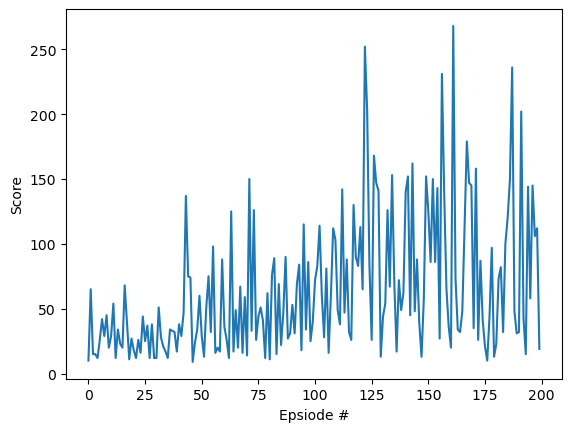

In [17]:
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Epsiode #')
plt.show()